# Resultados de la prueba subjetiva

Imports

In [1]:
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from pesq import pesq
from pymongo.server_api import ServerApi
from pathlib import Path
import soundfile as sf
import pandas as pd
from scipy.stats import pearsonr


Cargar la colección

In [2]:
uri = f"mongodb+srv://{st.secrets['db_username']}:{st.secrets['db_pswd']}@{st.secrets['cluster_name']}.j8rqe.mongodb.net/?retryWrites=true&w=majority&appName=test-subjetivo"

client = pymongo.MongoClient(uri, server_api=ServerApi('1'))
db = client["results_db"]
collection = db["results_collection"]

client.admin.command("ping")
print("Connected successfully")

Connected successfully


Leer los resultados

In [3]:
data = list(collection.find())
df = pd.DataFrame(data)
resultados = pd.json_normalize(df['resultados'])
df_final = pd.concat([df[['id_participante', 'edad', 'genero', 'sistema', 'experiencia']], resultados], axis=1)
df_final.to_csv('results.csv')

Estilo de los graficos

In [4]:
plt.style.use('bmh')
sns.set_theme(style="whitegrid", context="talk")

Ploteo los resultados para silentcipher

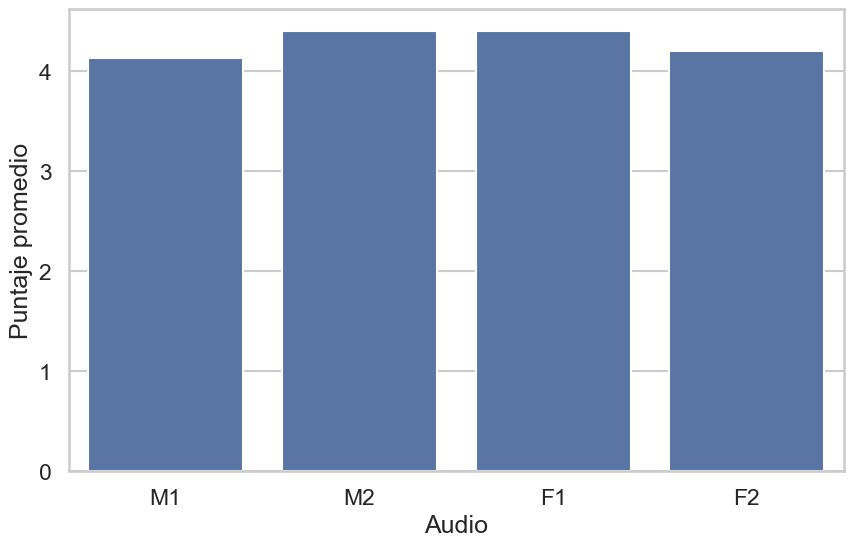

In [5]:

columns_as = [col for col in df_final.columns if col.endswith('_as')]
df_as = df_final[columns_as]

columns_sc = [col for col in df_final.columns if col.endswith('_sc')]
df_sc = df_final[columns_sc]

columns_wm = [col for col in df_final.columns if col.endswith('_wm')]
df_wm = df_final[columns_wm]

columns_or = [col for col in df_final.columns if col.endswith('_or')]
df_or = df_final[columns_or]

puntajes_promedio_or = df_or.mean()
puntajes_promedio_or.index = puntajes_promedio_or.index.str.replace('_or', '')
puntajes_promedio_or = puntajes_promedio_or.reindex(['M1', 'M2', 'F1', 'F2'])

plt.figure(figsize=(10, 6))
sns.barplot(x=puntajes_promedio_or.index, y=puntajes_promedio_or.values)
plt.ylabel('Puntaje promedio')
plt.xlabel('Audio')
plt.xticks()  # Rotar las etiquetas si es necesario
plt.savefig('plots/original.svg')
plt.show()

Comparaciones A/A: 4.28 stdev: 0.85
Silentcipher: 4.12 stdev: 0.80
Audioseal: 4.08 stdev: 1.00
Wavmark: 3.53 stdev: 1.05


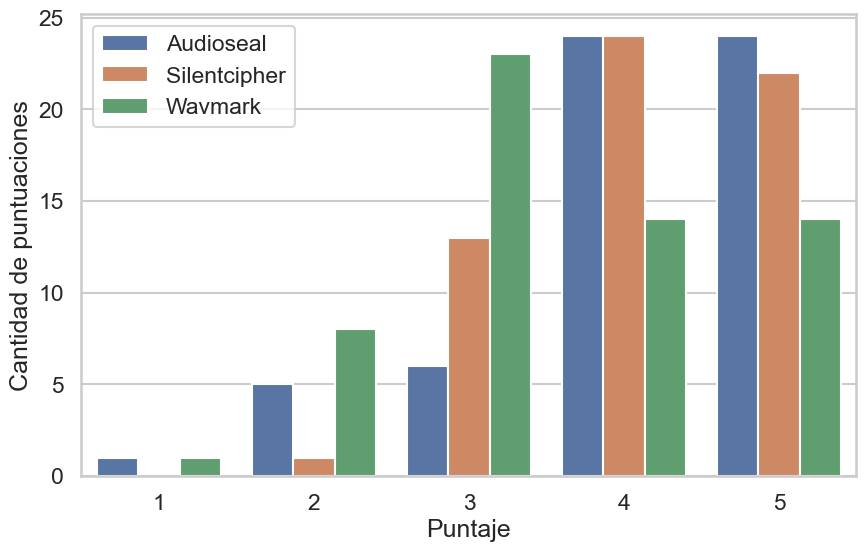

In [6]:
puntajes_as = df_as.melt(value_name='puntaje')['puntaje']
puntajes_sc = df_sc.melt(value_name='puntaje')['puntaje']
puntajes_wm = df_wm.melt(value_name='puntaje')['puntaje']
puntajes_or = df_or.melt(value_name='puntaje')['puntaje']

print(f'Comparaciones A/A: {puntajes_or.mean():.2f} stdev: {puntajes_or.std():.2f}')
print(f'Silentcipher: {puntajes_sc.mean():.2f} stdev: {puntajes_sc.std():.2f}')
print(f'Audioseal: {puntajes_as.mean():.2f} stdev: {puntajes_as.std():.2f}')
print(f'Wavmark: {puntajes_wm.mean():.2f} stdev: {puntajes_wm.std():.2f}')


puntajes_posibles = range(1, 6)

frecuencias_puntajes_as = puntajes_as.value_counts().reindex(puntajes_posibles, fill_value=0).sort_index()
frecuencias_puntajes_sc = puntajes_sc.value_counts().reindex(puntajes_posibles, fill_value=0).sort_index()
frecuencias_puntajes_wm = puntajes_wm.value_counts().reindex(puntajes_posibles, fill_value=0).sort_index()
frecuencias_puntajes_or = puntajes_or.value_counts().reindex(puntajes_posibles, fill_value=0).sort_index()

frecuencias_df = pd.DataFrame({
    'Audioseal': frecuencias_puntajes_as,
    'Silentcipher': frecuencias_puntajes_sc,
    'Wavmark': frecuencias_puntajes_wm})

# Crear un DataFrame para cada sistema con una columna 'Sistema' indicando el origen
df_as_long = pd.DataFrame({'puntaje': puntajes_as, 'Sistema': 'Audioseal'})
df_sc_long = pd.DataFrame({'puntaje': puntajes_sc, 'Sistema': 'Silentcipher'})
df_wm_long = pd.DataFrame({'puntaje': puntajes_wm, 'Sistema': 'Wavmark'})
df_or_long = pd.DataFrame({'puntaje': puntajes_or, 'Sistema': 'Original'})

# Combinar todos los DataFrames en uno solo
df_combined = pd.concat([df_as_long, df_sc_long, df_wm_long])
df_combined['Sistema'] = pd.Categorical(df_combined['Sistema'], categories=['Audioseal', 'Silentcipher', 'Wavmark'], ordered=True)

frecuencia_puntajes = df_combined.groupby(['puntaje', 'Sistema'], observed=True).size().reset_index(name='Frecuencia')

# Crear el histograma con seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='puntaje', y='Frecuencia', hue='Sistema', data=frecuencia_puntajes, dodge=True)

plt.xlabel('Puntaje')
plt.ylabel('Cantidad de puntuaciones')
plt.xticks()
plt.legend()
plt.savefig('plots/dmos_histograma.svg')
plt.show()


C:\Users\jalma\AppData\Local\Temp\ipykernel_11272\860105544.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Sistema', y='puntaje', data=df_combined, inner="box", scale='width')


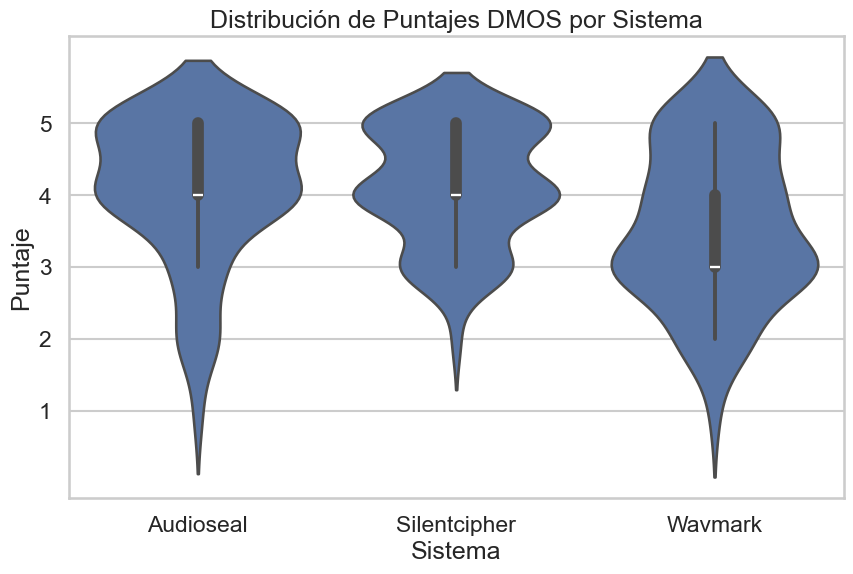

In [7]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Sistema', y='puntaje', data=df_combined, inner="box", scale='width')

# Configurar etiquetas y título
plt.ylabel('Puntaje')
plt.yticks([1, 2, 3, 4, 5])
plt.title('Distribución de Puntajes DMOS por Sistema')

# Guardar el gráfico
plt.savefig('plots/dmos_violinplot.svg')
plt.show()

In [8]:
def signal_noise_ratio(original, signal_watermarked):
    """
    Calculates the signal-to-noise ratio between the original and watermarked signals.

    Args:
        original (np.array): Original audio signal.
        signal_watermarked (np.array): Watermarked audio signal.

    Returns:
        float: The signal-to-noise ratio in dB.
    """
    original, signal_watermarked = to_equal_length(original, signal_watermarked)
    noise_strength = np.sum((original - signal_watermarked) ** 2)
    if noise_strength == 0:
        return np.inf
    signal_strength = np.sum(original ** 2)
    ratio = signal_strength / noise_strength
    return 10 * np.log10(ratio)

def to_equal_length(original, signal_watermarked):
    """
    Adjusts the length of the original and watermarked signals to be the same.
    """
    if original.shape != signal_watermarked.shape:
        print("Warning: length not equal:", len(original), len(signal_watermarked))
        min_length = min(len(original), len(signal_watermarked))
        original = original[:min_length]
        signal_watermarked = signal_watermarked[:min_length]
    assert original.shape == signal_watermarked.shape
    return original, signal_watermarked

Calcular metricas objetivas de las muestras

In [9]:
def get_speaker_id(file_name):
    return file_name[:2] 

# Sistemas
systems = ['audioseal', 'silentcipher', 'wavmark']

# Carpeta con los audios originales
original_folder = Path('data/audio_samples/original')
original_files = list(original_folder.glob('*.wav'))

# Inicializar una lista para almacenar los resultados
results = []

# Iterar sobre los sistemas
for system in systems:
    system_folder = Path(f'data/audio_samples/{system}')
    system_files = list(system_folder.glob('*.wav'))
    
    # Iterar sobre los archivos originales y buscar los correspondientes en el sistema actual
    for or_file in original_files:
        speaker_id = get_speaker_id(or_file.stem)  # Obtener el identificador del hablante
        matching_file = next((file for file in system_files if get_speaker_id(file.stem) == speaker_id), None)
        
        if matching_file:
            audio, _ = sf.read(or_file)
            watermarked_signal, _ = sf.read(matching_file)
            snr = signal_noise_ratio(audio, watermarked_signal)
            pesq_score = pesq(16000, audio, watermarked_signal)

            # Agregar los resultados a la lista
            results.append({
                'speaker_id': speaker_id,
                'system': system,
                'snr': snr,
                'pesq': pesq_score
            })

# Convertir los resultados a un DataFrame de pandas y guardarlos en un CSV
df = pd.DataFrame(results)
df.to_csv('old_comparison_results.csv', index=False)

print("Resultados guardados en 'comparison_results.csv'.")

Resultados guardados en 'comparison_results.csv'.


Ahora quiero generar un csv con los resultados objetivos y los subjetivos para compararlos

In [10]:
# Cargar el CSV con los puntajes
df_puntajes = pd.read_csv('results.csv')

# Cargar el CSV con snr y pesq
df_resultados = pd.read_csv('comparison_results.csv')

# Calcular el promedio de los puntajes por cada archivo de audio (ignorando las primeras 5 columnas que no son puntajes)
dmos_columns = df_puntajes.columns[6:]  # Las columnas con los nombres de archivo
promedios_dmos = df_puntajes[dmos_columns].mean(axis=0)

# Crear un DataFrame con los promedios calculados
df_promedios = pd.DataFrame(promedios_dmos, columns=['dmos']).reset_index()
df_promedios.columns = ['file_name', 'dmos']

# Unir ambos DataFrames en base a la columna 'file_name'
df_final = pd.merge(df_resultados, df_promedios, on='file_name')

# Guardar el nuevo CSV con la columna dmos añadida
df_final.to_csv('archivo_resultados_con_dmos.csv', index=False)

print("Archivo con promedios DMOS guardado en 'archivo_resultados_con_dmos.csv'.")


Archivo con promedios DMOS guardado en 'archivo_resultados_con_dmos.csv'.


<Figure size 1000x600 with 0 Axes>

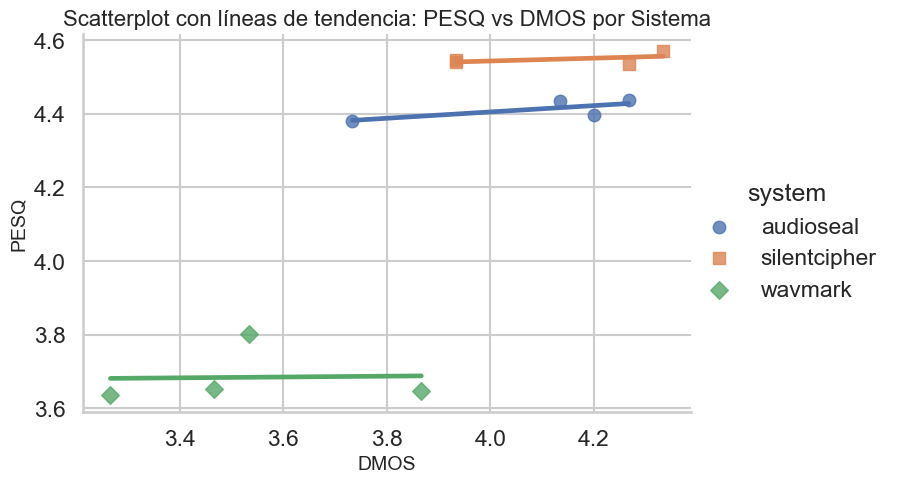

Correlación de Pearson para audioseal: 0.7518
Correlación de Pearson para silentcipher: 0.5212
Correlación de Pearson para wavmark: 0.0356


In [11]:
# Cargar el CSV
df = pd.read_csv('archivo_resultados_con_dmos.csv')

# Crear una nueva columna 'system' basada en los últimos dos caracteres de 'file_name'
df['system'] = df['file_name'].apply(lambda x: x[-2:])

# Definir un diccionario para traducir los códigos de sistema
system_names = {
    'as': 'audioseal',
    'sc': 'silentcipher',
    'wm': 'wavmark'
}

# Reemplazar los códigos de sistema por los nombres reales
df['system'] = df['system'].map(system_names)

# Crear un scatterplot con líneas de tendencia por sistema
plt.figure(figsize=(10, 6))
sns.lmplot(data=df, x='dmos', y='pesq', hue='system', markers=["o", "s", "D"], aspect=1.5, ci=None)

# Agregar etiquetas y título
plt.title('Scatterplot con líneas de tendencia: PESQ vs DMOS por Sistema', fontsize=16)
plt.xlabel('DMOS', fontsize=14)
plt.ylabel('PESQ', fontsize=14)

# Mostrar el gráfico
plt.show()

# Calcular la correlación de Pearson para cada sistema
for system in df['system'].unique():
    subset = df[df['system'] == system]
    corr, _ = pearsonr(subset['dmos'], subset['pesq'])
    print(f'Correlación de Pearson para {system}: {corr:.4f}')


A ver los puntajes por sistema de escucha y experiencia

  watermark_system                              experiencia   puntaje
0        Audioseal              Escucho música regularmente  3.861111
1        Audioseal                 No suelo escuchar música  4.500000
2        Audioseal  Trabajo/estudio relacionado a la música  4.400000
3     Silentcipher              Escucho música regularmente  4.083333
4     Silentcipher                 No suelo escuchar música  3.750000
5     Silentcipher  Trabajo/estudio relacionado a la música  4.250000
6          Wavmark              Escucho música regularmente  3.472222
7          Wavmark                 No suelo escuchar música  4.500000
8          Wavmark  Trabajo/estudio relacionado a la música  3.450000


C:\Users\jalma\AppData\Local\Temp\ipykernel_11272\2350841500.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_grouped, x='watermark_system', y='puntaje', hue='experiencia', ci=None)


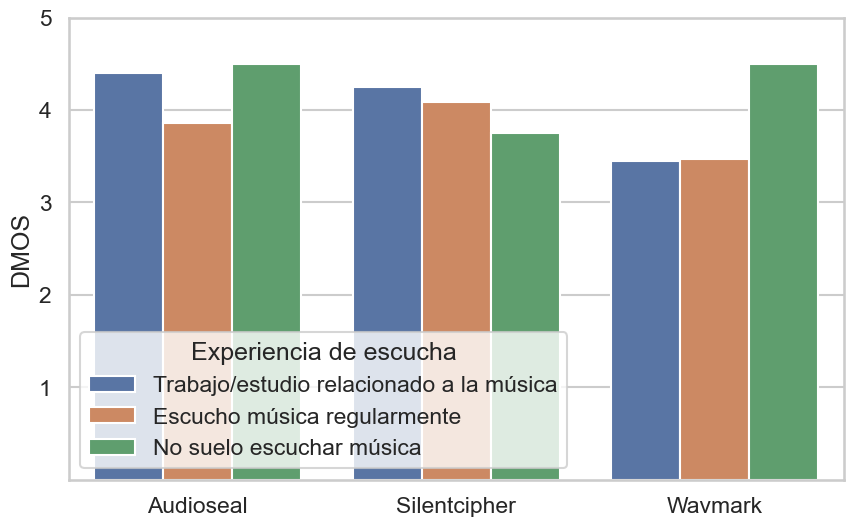

In [48]:
# Cargar los datos
df = pd.read_csv('results.csv')  # Reemplaza 'results.csv' con el nombre de tu archivo

# Filtrar las columnas de archivos de audio y sus sistemas de marcas de agua
audio_columns = df.columns[6:]  # Selecciona las columnas de archivos de audio
df_melted = df.melt(id_vars=['id_participante', 'edad', 'genero', 'sistema', 'experiencia'], 
                    value_vars=audio_columns, var_name='audio_file', value_name='puntaje')

# Extraer el sistema de marcas de agua de los últimos dos caracteres de la columna 'audio_file'
df_melted['watermark_system'] = df_melted['audio_file'].str[-2:]

# Filtrar los sistemas sc, wm, as
df_filtered = df_melted[df_melted['watermark_system'].isin(['sc', 'wm', 'as'])]

# Calcular el promedio de puntajes para cada combinación de sistema de marcas de agua y experiencia
df_grouped = df_filtered.groupby(['watermark_system', 'experiencia'])['puntaje'].mean().reset_index()

# Reemplazar 'as', 'sc' y 'wm' con nombres completos
df_grouped['watermark_system'] = df_grouped['watermark_system'].replace({
    'as': 'Audioseal',
    'sc': 'Silentcipher',
    'wm': 'Wavmark'
})
print(df_grouped)
df_grouped['experiencia'] = pd.Categorical(df_grouped['experiencia'], categories=['Trabajo/estudio relacionado a la música', 'Escucho música regularmente', 'No suelo escuchar música'], ordered=True)
# Crear el gráfico de barras con etiquetas descriptivas
plt.figure(figsize=(10, 6))
sns.barplot(data=df_grouped, x='watermark_system', y='puntaje', hue='experiencia', ci=None)
plt.xlabel('')  # Etiqueta para el eje X
plt.ylabel('DMOS')
plt.yticks([1, 2, 3, 4, 5])
plt.legend(title='Experiencia de escucha', loc=3)
plt.show()